# ENIGMA Explorer API Examples

## Phylogenic Tree of FW305-130 relatives

In [7]:
import requests

ISOLATE_ID = "FW305-130"
BASE_URL = "http://isolates.genomics.lbl.gov/api/v1"

# Search for the id of this isolate
idUrl = BASE_URL+"/isolates/isoid/" + ISOLATE_ID
idRes = requests.get(idUrl)
if idRes.status_code != 200 :
    print("Error in getting id:", idRes.status_code, idRes.json()["message"])
    raise KeyboardInterrupt
else :
    idJson = idRes.json()
    myId = idJson["id"]
    print('Id of', ISOLATE_ID, 'is', myId)

# Retrieve the top 50 BLAST hits of its 16s sequence
bUrl = BASE_URL+"/ncbi/blast/isolates/" + str(myId)
bRes = requests.get(bUrl)
if bRes.status_code != 200 :
    print("Error in BLAST:", bRes.status_code, bRes.json()["message"])
    raise KeyboardInterrupt
else :
    bJson = bRes.json()
    hits = [ j["isoid"] for j in bJson ]

# Again, use /isolates/isoid to get the 16s seq
rrnas = []
for hit in hits :
    rUrl = BASE_URL+"/isolates/isoid/" + hit
    rRes = requests.get(rUrl)
    rJson = rRes.json()
    if "rrna" not in rJson :
        continue
    rrnas.append(rJson["rrna"])
# Write rrnas to fasta
path = "hits.fasta"
fo = open(path, 'w')
for hit, rrna in zip(hits, rrnas) :
    if rrna == "" :
        continue
    fo.write('>' + hit + '\n')
    fo.write(rrna + '\n')
fo.close()
    

Id of FW305-130 is 1


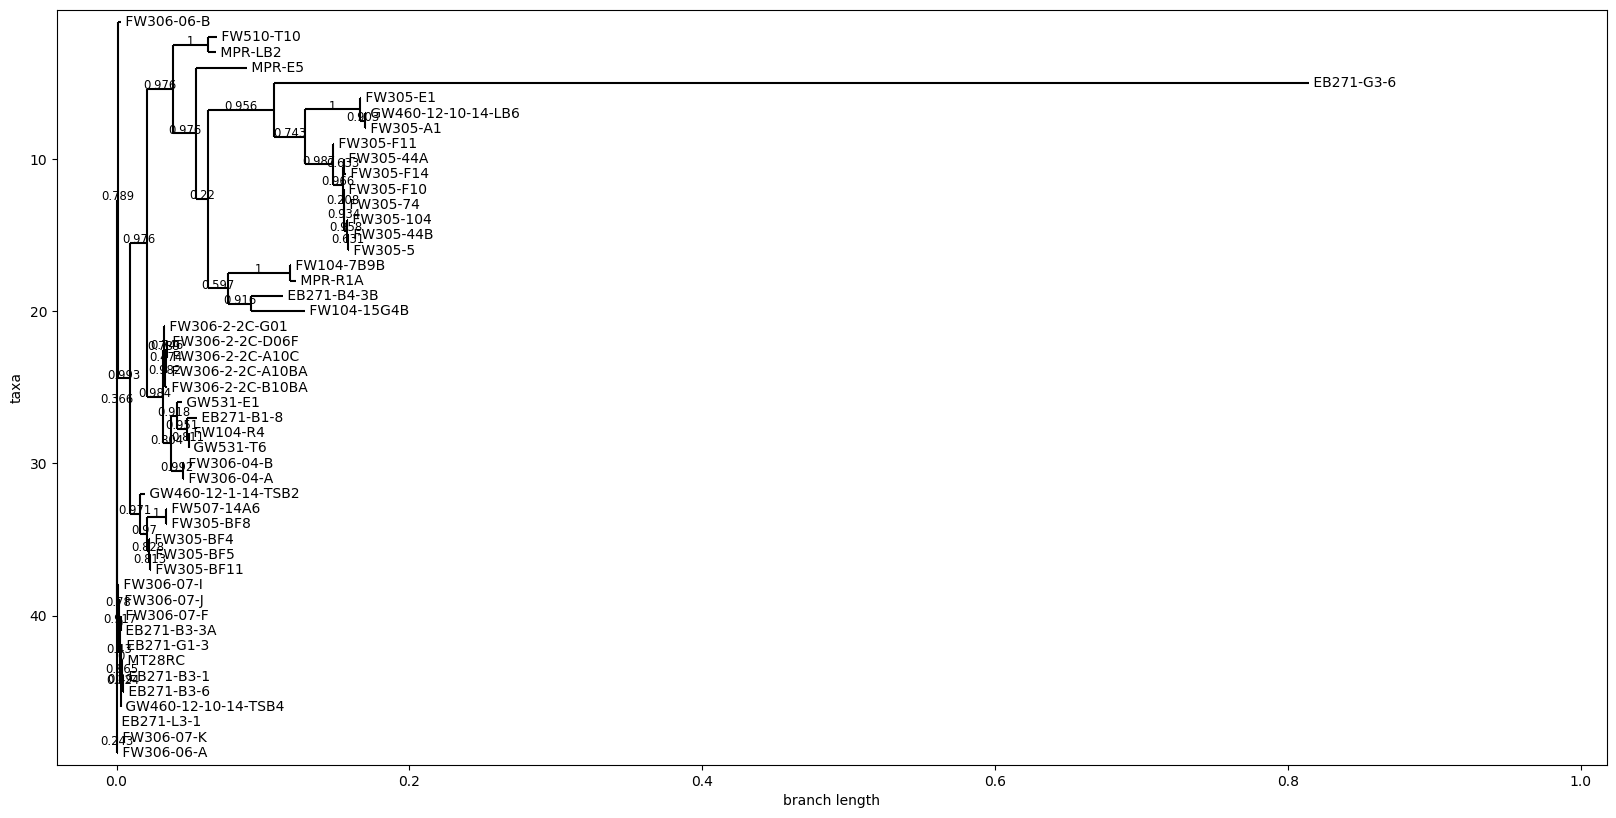

In [13]:
%matplotlib inline
from Bio import Phylo
import matplotlib.pyplot as plt

tree = Phylo.read('hits.nwk', 'newick')
# set tree size
fig = plt.figure(figsize=(20, 10), dpi=100)
axes = fig.add_subplot(1, 1, 1)
Phylo.draw(tree, axes=axes)